# Polygon Analysis: Clockwise Ordering, Triangulation, and Barycenter

This notebook:
1. Orders coordinates clockwise
2. Triangulates the polygon
3. Calculates the barycenter using triangle areas as weights
4. Plots the polygon on a real map

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import folium
from folium import PolyLine

## 1. Define Coordinates

In [12]:
# Original coordinates (latitude, longitude)
coordenadas = np.array([
    (-22.952283755095475, -43.18650962935336),
    (-22.997365243417146, -43.42241573374337),
    (-23.002184625016696, -43.39279915352904),
    (-23.001515038547513, -43.36167347028977),
    (-23.001434357123674, -43.358965083563135),
    (-22.995787959399564, -43.25534187225521),
    (-23.007990780671623, -43.32662652022635),
    (-22.96431416341436, -43.385883674594936),
    (-22.935880640315393, -43.338991425795456),
    (-22.953135101574567, -43.343971422090235),
])

print(f"Number of points: {len(coordenadas)}")
print(f"Coordinates shape: {coordenadas.shape}")

Number of points: 10
Coordinates shape: (10, 2)


## 2. Order Coordinates Clockwise

To order points clockwise, we:
1. Calculate the centroid
2. Calculate the angle from centroid to each point
3. Sort by angle in descending order (for clockwise)

In [13]:
def order_points_clockwise(points):
    """
    Order points in clockwise direction around their centroid.
    
    Args:
        points: numpy array of shape (n, 2) with (lat, lon) coordinates
    
    Returns:
        Ordered points in clockwise direction
    """
    # Calculate centroid
    centroid = np.mean(points, axis=0)
    
    # Calculate angles from centroid to each point
    # Using atan2(y, x) where y=lat-centroid_lat, x=lon-centroid_lon
    angles = np.arctan2(
        points[:, 0] - centroid[0],  # lat difference
        points[:, 1] - centroid[1]   # lon difference
    )
    
    # Sort by angle in descending order for clockwise
    sorted_indices = np.argsort(-angles)
    
    return points[sorted_indices]

# Order the coordinates
ordered_coords = order_points_clockwise(coordenadas)

print("Ordered coordinates (clockwise):")
for i, coord in enumerate(ordered_coords):
    print(f"{i}: {coord}")

Ordered coordinates (clockwise):
0: [-22.96431416 -43.38588367]
1: [-22.9531351  -43.34397142]
2: [-22.93588064 -43.33899143]
3: [-22.95228376 -43.18650963]
4: [-22.99578796 -43.25534187]
5: [-23.00799078 -43.32662652]
6: [-23.00143436 -43.35896508]
7: [-23.00151504 -43.36167347]
8: [-23.00218463 -43.39279915]
9: [-22.99736524 -43.42241573]


## 3. Triangulate the Polygon

We'll use Delaunay triangulation to divide the polygon into triangles.

In [14]:
# Perform Delaunay triangulation
triangulation = Delaunay(ordered_coords)

print(f"Number of triangles: {len(triangulation.simplices)}")
print(f"\nTriangle indices:")
for i, simplex in enumerate(triangulation.simplices):
    print(f"Triangle {i}: vertices {simplex}")

Number of triangles: 11

Triangle indices:
Triangle 0: vertices [3 4 2]
Triangle 1: vertices [7 6 5]
Triangle 2: vertices [0 6 7]
Triangle 3: vertices [0 8 9]
Triangle 4: vertices [8 0 7]
Triangle 5: vertices [8 7 5]
Triangle 6: vertices [1 0 2]
Triangle 7: vertices [1 6 0]
Triangle 8: vertices [6 1 5]
Triangle 9: vertices [1 4 5]
Triangle 10: vertices [4 1 2]


## 4. Calculate Barycenter with Area Weights

The barycenter is calculated as the weighted average of triangle centroids,
where the weight is the area of each triangle.

In [15]:
def triangle_area(p1, p2, p3):
    """
    Calculate the area of a triangle given three points using the cross product formula.
    For geographic coordinates, this gives an approximate area.
    
    Args:
        p1, p2, p3: Points as (lat, lon) tuples or arrays
    
    Returns:
        Area of the triangle
    """
    # Using the cross product formula: 0.5 * |AB x AC|
    # where AB = p2 - p1 and AC = p3 - p1
    area = 0.5 * abs(
        (p2[0] - p1[0]) * (p3[1] - p1[1]) - 
        (p3[0] - p1[0]) * (p2[1] - p1[1])
    )
    return area

def calculate_barycenter(points, triangulation):
    """
    Calculate the barycenter of a polygon using triangle area weights.
    
    Args:
        points: numpy array of shape (n, 2) with coordinates
        triangulation: Delaunay triangulation object
    
    Returns:
        Barycenter coordinates as (lat, lon)
    """
    total_area = 0
    weighted_centroid = np.array([0.0, 0.0])
    
    triangle_data = []
    
    for simplex in triangulation.simplices:
        # Get the three vertices of the triangle
        p1, p2, p3 = points[simplex]
        
        # Calculate triangle area
        area = triangle_area(p1, p2, p3)
        
        # Calculate triangle centroid
        triangle_centroid = (p1 + p2 + p3) / 3
        
        # Accumulate weighted centroid
        weighted_centroid += area * triangle_centroid
        total_area += area
        
        triangle_data.append({
            'vertices': simplex,
            'area': area,
            'centroid': triangle_centroid
        })
    
    # Calculate final barycenter
    barycenter = weighted_centroid / total_area
    
    return barycenter, total_area, triangle_data

# Calculate barycenter
barycenter, total_area, triangle_data = calculate_barycenter(ordered_coords, triangulation)

print(f"Barycenter (weighted by triangle areas):")
print(f"  Latitude:  {barycenter[0]:.10f}")
print(f"  Longitude: {barycenter[1]:.10f}")
print(f"\nTotal polygon area (approximate): {total_area:.10f}")
print(f"\nTriangle details:")
for i, data in enumerate(triangle_data):
    print(f"  Triangle {i}: Area = {data['area']:.10f}, Centroid = {data['centroid']}")

Barycenter (weighted by triangle areas):
  Latitude:  -22.9728369642
  Longitude: -43.3101193199

Total polygon area (approximate): 0.0102439710

Triangle details:
  Triangle 0: Area = 0.0038813312, Centroid = [-22.96131745 -43.26028098]
  Triangle 1: Area = 0.0000101832, Centroid = [-23.00364673 -43.34908836]
  Triangle 2: Area = 0.0000513538, Centroid = [-22.98908785 -43.36884074]
  Triangle 3: Area = 0.0005774609, Centroid = [-22.98795468 -43.40036619]
  Triangle 4: Area = 0.0005870567, Centroid = [-22.98933794 -43.38011877]
  Triangle 5: Area = 0.0001125144, Centroid = [-23.00389681 -43.36036638]
  Triangle 6: Area = 0.0003337508, Centroid = [-22.95110997 -43.35628217]
  Triangle 7: Area = 0.0009283578, Centroid = [-22.97296121 -43.36294006]
  Triangle 8: Area = 0.0008301167, Centroid = [-22.98752008 -43.34318768]
  Triangle 9: Area = 0.0020610123, Centroid = [-22.98563795 -43.3086466 ]
  Triangle 10: Area = 0.0008708331, Centroid = [-22.96160123 -43.31276824]


## 5. Visualize Triangulation (Optional)

Simple plot to visualize the triangulation structure.

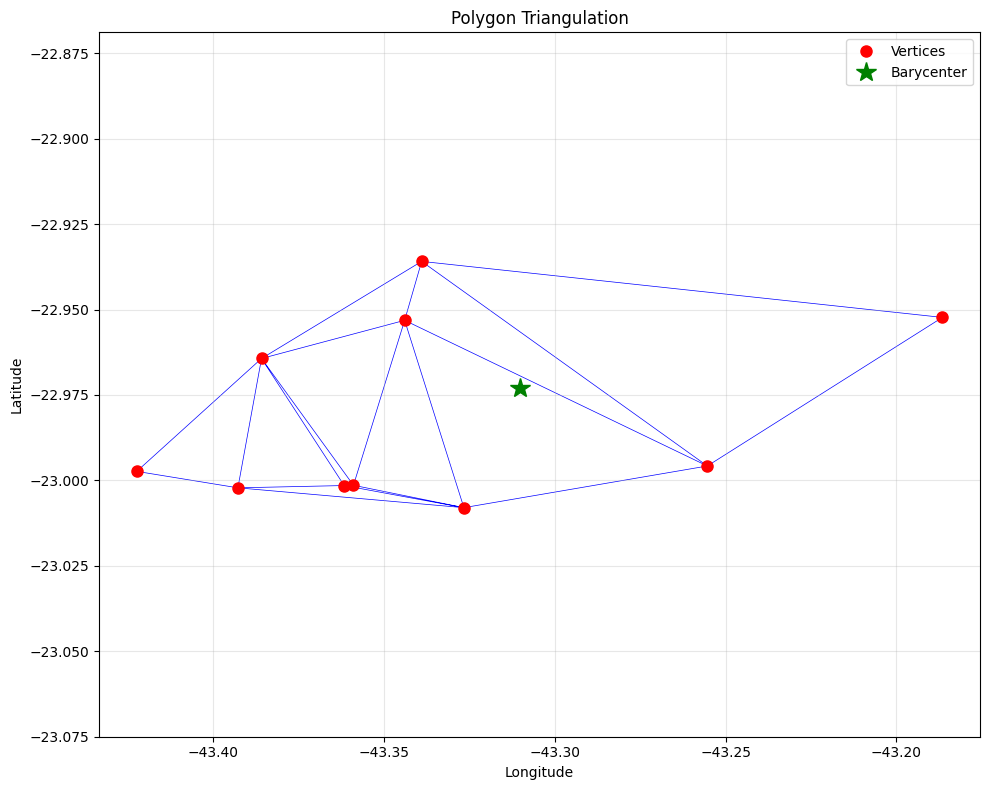

In [16]:
plt.figure(figsize=(10, 8))
plt.triplot(ordered_coords[:, 1], ordered_coords[:, 0], triangulation.simplices, 'b-', linewidth=0.5)
plt.plot(ordered_coords[:, 1], ordered_coords[:, 0], 'ro', markersize=8, label='Vertices')
plt.plot(barycenter[1], barycenter[0], 'g*', markersize=15, label='Barycenter')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygon Triangulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 6. Plot Polygon on Real Map

Using Folium to display the polygon on an interactive map.

In [ ]:
# Calculate closest vertex to barycenter for visualization
distances = np.sqrt(np.sum((ordered_coords - barycenter)**2, axis=1))
closest_idx = np.argmin(distances)
closest_vertex = ordered_coords[closest_idx]

# Create map centered on the barycenter
m = folium.Map(
    location=[barycenter[0], barycenter[1]],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Create polygon by closing the loop (add first point at the end)
polygon_coords = np.vstack([ordered_coords, ordered_coords[0]])

# Add polygon outline
folium.PolyLine(
    locations=polygon_coords.tolist(),
    color='blue',
    weight=3,
    opacity=0.8,
    popup='Polygon boundary'
).add_to(m)

# Add polygon fill
folium.Polygon(
    locations=ordered_coords.tolist(),
    color='blue',
    fill=True,
    fill_color='lightblue',
    fill_opacity=0.3,
    popup='Polygon area'
).add_to(m)

# Add markers for vertices
for i, coord in enumerate(ordered_coords):
    color = 'magenta' if i == closest_idx else 'red'
    fill_color = 'magenta' if i == closest_idx else 'red'
    folium.CircleMarker(
        location=[coord[0], coord[1]],
        radius=5,
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        popup=f'Vertex {i}: ({coord[0]:.6f}, {coord[1]:.6f})'
    ).add_to(m)

# Add marker for barycenter
folium.Marker(
    location=[barycenter[0], barycenter[1]],
    popup=f'Barycenter: ({barycenter[0]:.6f}, {barycenter[1]:.6f})',
    icon=folium.Icon(color='green', icon='star')
).add_to(m)

# Draw line from barycenter to closest vertex
folium.PolyLine(
    locations=[[barycenter[0], barycenter[1]], [closest_vertex[0], closest_vertex[1]]],
    color='red',
    weight=3,
    opacity=0.8,
    dashArray='10, 5',
    popup=f'Line to closest vertex (index {closest_idx})'
).add_to(m)

# Display the map
m

## 7. Summary Statistics

In [18]:
print("=" * 60)
print("POLYGON ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nNumber of vertices: {len(ordered_coords)}")
print(f"Number of triangles: {len(triangulation.simplices)}")
print(f"\nBarycenter coordinates:")
print(f"  Latitude:  {barycenter[0]:.10f}")
print(f"  Longitude: {barycenter[1]:.10f}")
print(f"\nApproximate total area: {total_area:.10f} square degrees")
print(f"\nArea distribution:")
areas = [t['area'] for t in triangle_data]
print(f"  Min triangle area: {min(areas):.10f}")
print(f"  Max triangle area: {max(areas):.10f}")
print(f"  Mean triangle area: {np.mean(areas):.10f}")
print(f"  Std triangle area: {np.std(areas):.10f}")
print("=" * 60)

POLYGON ANALYSIS SUMMARY

Number of vertices: 10
Number of triangles: 11

Barycenter coordinates:
  Latitude:  -22.9728369642
  Longitude: -43.3101193199

Approximate total area: 0.0102439710 square degrees

Area distribution:
  Min triangle area: 0.0000101832
  Max triangle area: 0.0038813312
  Mean triangle area: 0.0009312701
  Std triangle area: 0.0010823702


## 8. Find Closest Vertex to Barycenter

Find which vertex is closest to the calculated barycenter.

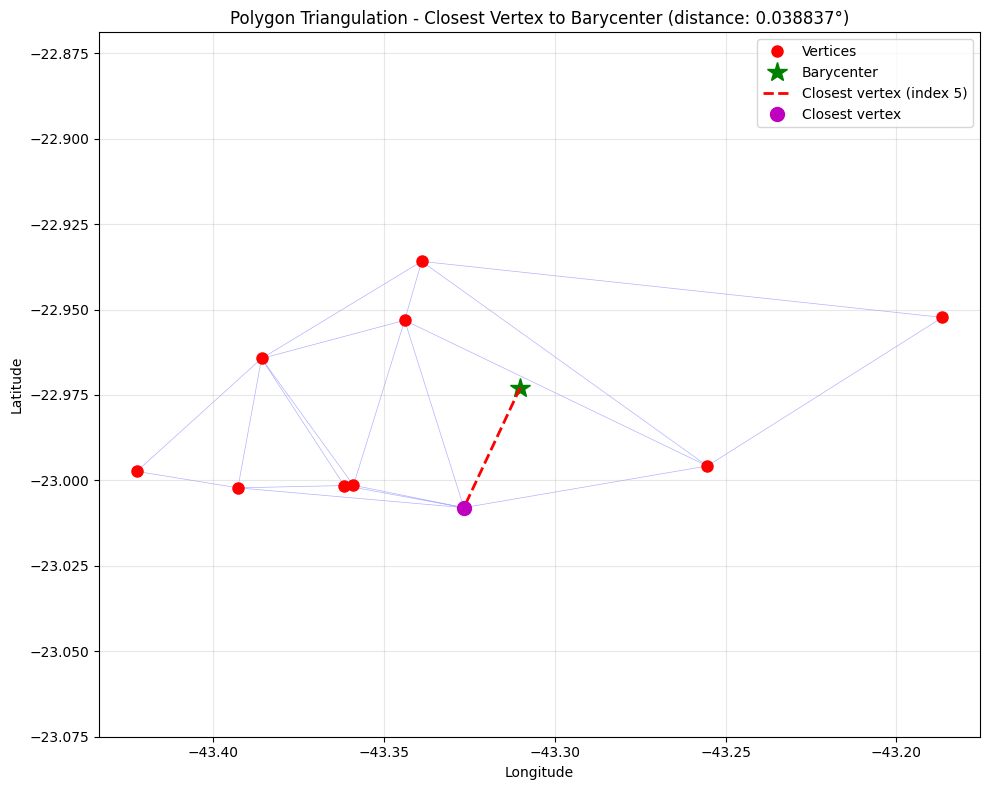

Closest vertex index: 5
Closest vertex coordinates: (-23.0079907807, -43.3266265202)
Distance to barycenter: 0.0388365610 degrees


In [19]:
# Calculate distances from each vertex to the barycenter
distances = np.sqrt(np.sum((ordered_coords - barycenter)**2, axis=1))

# Find the index of the closest vertex
closest_idx = np.argmin(distances)
closest_distance = distances[closest_idx]
closest_vertex = ordered_coords[closest_idx]

# Visualize the line between barycenter and closest vertex
plt.figure(figsize=(10, 8))
plt.triplot(ordered_coords[:, 1], ordered_coords[:, 0], triangulation.simplices, 'b-', linewidth=0.5, alpha=0.3)
plt.plot(ordered_coords[:, 1], ordered_coords[:, 0], 'ro', markersize=8, label='Vertices')
plt.plot(barycenter[1], barycenter[0], 'g*', markersize=15, label='Barycenter')
# Draw line from barycenter to closest vertex
plt.plot([barycenter[1], closest_vertex[1]], [barycenter[0], closest_vertex[0]], 
         'r--', linewidth=2, label=f'Closest vertex (index {closest_idx})')
plt.plot(closest_vertex[1], closest_vertex[0], 'mo', markersize=10, label='Closest vertex')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Polygon Triangulation - Closest Vertex to Barycenter (distance: {closest_distance:.6f}°)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"Closest vertex index: {closest_idx}")
print(f"Closest vertex coordinates: ({closest_vertex[0]:.10f}, {closest_vertex[1]:.10f})")
print(f"Distance to barycenter: {closest_distance:.10f} degrees")